## 1. Collect Basic Data

### Retrieve CryptoCurrency Market Data ###

In [1]:
import pandas as pd
import yfinance as yf
from functools import reduce
import requests
import time
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


CRYPTO = False

# Crypto Details
cryptoProducts = ["ETH-USD", "USDT-USD", "BTC-USD"]
availableGranularities = dict(zip(["1M", "5M", "15M", "1H", "6H", "1D"], [60, 300, 900, 3600, 21600, 86400]))

# Stock Details
dowTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "ULVR.L"]  
period = "1D"
indexProducts = dowTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

if CRYPTO:
    productIds = cryptoProducts
    period = "6H"
    granularity = availableGranularities[period]
    API_THRESHOLD = 300 #Can only get 300 periods at a time from API
    PERIODS_WANTED = 2500

# not a chance
def retrieveCryptoData(productID, granularity, daysBack, endTime):
    API_URL = f"https://api.exchange.coinbase.com/products/{productID}/candles"
    daysBackDaysAgo = timedelta(days=daysBack)
    startTime = datetime.fromisoformat(endTime) - (granularity/86400) * daysBackDaysAgo

    # Convert to isoformat
    startTime = startTime.isoformat()

    # Set Request Parameters
    parameters = {
        "start" : startTime,
        "end" : endTime,
        "granularity" : str(granularity)
    }

    # Actually get data
    data = requests.get(API_URL, params = parameters, headers = {"content-type":"application/json"})
    df = pd.DataFrame(data.json(), columns=["time", "low", "high", "open", "close", "volume"])
    return df


def retrieveIndexData(ticker):
    # Define date range
    startDate = "2009-01-01"
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc


dataframes = dict()
RETRIEVE_DATA = False

if RETRIEVE_DATA:
    for productId in productIds:
        if CRYPTO:
            # Fetch PERIODS_WANTED periods of data
            end = (datetime.now()).isoformat()
            for batch in range(PERIODS_WANTED // API_THRESHOLD  + 1):
                amountToFetch = PERIODS_WANTED % API_THRESHOLD if batch == PERIODS_WANTED // API_THRESHOLD else API_THRESHOLD
                tempDF = retrieveCryptoData(productId, granularity, amountToFetch, end)
                timeInSeconds = (tempDF['time'].values)[-1]
                dt = datetime.fromtimestamp(timeInSeconds - granularity)
                end = dt.isoformat() + 'Z'
                value = dataframes.get(productId)
                if productId not in dataframes:
                    dataframes[productId] = tempDF[::-1]
                else:
                    dataframes[productId] = pd.concat([tempDF[::-1], dataframes[productId]])
        else:
            dataframe = retrieveIndexData(ticker=productId)
            columnNames = [value[1].lower() for value in list(dataframe.columns.values)]
            dataframe.columns = columnNames
            dataframes[productId] = dataframe
   
# Required for index data that pull stock data from different exchanges
def commonaliseData(data):
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    data = {ticker: df.dropna() for ticker, df in data.items()}
    PERIODS_WANTED = data.get(indexProducts[0]).shape[0]
    return data

if not CRYPTO and RETRIEVE_DATA:
    dataframes = commonaliseData(dataframes)

In [2]:
TEST_CORRECT_ORDER = False

if TEST_CORRECT_ORDER:
    testTime = dataframes[productIds[0]]['time'].values
    testTime -= testTime[0]
    plt.figure(figsize=(10, 6))
    plt.plot(testTime, color="blue")
    plt.title(f"Test Correct Order")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

## 2. Augment State Space (add indicators)

### Indicator 1: Exponential Moving Average ###

In [3]:
import matplotlib.pyplot as plt

def EMA(array, N):
    """
    EMA_t = (Price_t * α) + (EMA_(t-1) * (1 - α))
    where:
    EMA_t = Exponential Moving Average at time t
    Price_t = Price at time t
    α (alpha) = Smoothing factor, calculated as 2 / (N + 1)
    N = Number of periods
    """
    smoothingParameter = 2/(N + 1)
    finalArray = [array[0]]
    for i in range(1, len(array)):
        finalArray.append(array[i] * smoothingParameter + finalArray[i-1] * (1 - smoothingParameter))
    return np.array(finalArray)

# expMA = EMA(closingPrices, t)
# plt.figure(figsize=(10, 6))
# plt.plot(expMA, label=f"Exponential Moving Average: T={t}", color="red")
# plt.plot(closingPrices, label="Actual Closing Prices", color="blue")
# plt.title(f"Price Data")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

### Indicator 2: Momemtum

In [4]:
def Momentum(array):
    # Percentage Change in Price/Time
    momentumArray = [(array[i] - array[i-1]) /array[i-1] for i in range(1, len(array))]
    momentumArray.insert(0, np.nan)
    return np.array(momentumArray)

# momentum = Momentum(closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(momentum*100, color="green")
# plt.title(f"Momentum Data (as %)")
# plt.xlabel("Time")
# plt.ylabel("Momentum")
# plt.legend()
# plt.show()

### Indicator 3: Average True Range

In [5]:

def trueRange(high, low, close):
    # TR = Max[(H - L), |H - C|, |L - C|
    closing = np.insert(close, 0, np.nan, axis=0)[:len(close)]
    return np.maximum(high - low, np.abs(high - closing), np.abs(low - closing))

def averageTrueRange(high, low, close, n=14):
    trueRanges = trueRange(high, low, close)
    atr = np.empty_like(trueRanges)
    atr[:n] = np.nan  # First n values are NaN
    atr[n-1] = np.mean(trueRanges[:n])  # Initial ATR value (simple average of the first n TRs)
    for i in range(n+1, len(trueRanges)):
        atr[i] = (atr[i-1] * (n - 1) + trueRanges[i]) / n
    return atr

# aTRIndicator = averageTrueRange(highs, lows, closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(aTRIndicator, color="Brown")
# plt.title(f"Average True Range over Time")
# plt.xlabel("Time")
# plt.ylabel("Average True Range")
# plt.legend()
# plt.show()

### Indicator 4: Commodity Channel Index

In [6]:
def commodityChannelIndex(high, low, close, n=20):
    # (Typical Price - 20_Day Moving Average) / .015 x Mean Deviation
    typicalPrices = (high + low + close) / 3
    
    movingAverage = np.full_like(high, np.nan)
    meanDeviation = np.full_like(high, np.nan)
    
    for i in range(n, len(typicalPrices)):
        movingAverage[i] = np.mean(typicalPrices[i-n:i])
        meanDeviation[i] = np.mean(np.abs(typicalPrices[i-n:i] - movingAverage[i]))
    
    cci = np.full_like(high, np.nan, dtype=np.float64)

    numerator = typicalPrices[n:] - movingAverage[n:]
    denominator = 0.015 * meanDeviation[n:]
    result = np.empty_like(numerator)

    np.divide(numerator, denominator, out=result, where=(denominator != 0))
    # a little hacky...
    result[denominator == 0] = 0

    cci[n:] = result
    return cci

# # CCI = commodityChannelIndex(highs, lows, closingPrices)
# # plt.figure(figsize=(10, 6))
# # plt.plot(CCI, color="black")
# # plt.title(f"Commodity Channel Index over Time")
# # plt.xlabel("Time")
# # plt.ylabel("Commodity Channel Index")
# # plt.legend()
# # plt.show()

### Indicator 5: MACD

In [7]:
"""
MACD = 12-day EMA - 26-day EMA
Signal Line = 9-day EMA of MACD
MACD Histogram = MACD - Signal Line
where EMA stands for Exponential Moving Average
"""

def MACD(array):
    return EMA(array, 12) - EMA(array, 26)

def MACDSignal(array):
    return EMA(MACD(array), 9)

MACDHistogram = lambda x : MACD(x) - MACDSignal(x)

# mACD = MACD(closingPrices)
# signalLine = MACDSignal(closingPrices)
# macdHistogram = MACDHistogram(mACD, signalLine)

# plt.figure(figsize=(10, 6))
# plt.plot(mACD, color="blue", label = "MACD Line")
# plt.plot(signalLine, color = "red", label = "Signal Line")
# plt.plot(macdHistogram, color = "black", label = "Histogram")
# plt.title(f"Moving Average Convergence-Divergence")
# plt.xlabel("Time")
# plt.ylabel("MACD")
# plt.legend()
# plt.show()

## 3. Collate All Features Into DataFrame

In [8]:
import os

CCI_T, ATR_T = 20, 14
if RETRIEVE_DATA:
    for product in productIds:
        df = dataframes[product]
        close = df["close"].values
        highs = df["high"].values
        lows = df["low"].values
        df['E_M_A'] = EMA(close, N=30)
        df['Momentum'] = Momentum(close)
        df['Av_True_Range'] = averageTrueRange(highs, lows, close, 14)
        df['CCI'] = commodityChannelIndex(highs, lows, close, 20)
        df['MACDHist'] = MACDHistogram(close)
        df["Return"] = df["close"].pct_change().fillna(0)
        # Reset Indexes
        df = df.drop(columns=['open', 'high', 'volume', 'low'])
        df = df.iloc[max(ATR_T, CCI_T):]
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first column

times = None
if not CRYPTO:
    for product in productIds:
        df = dataframes[product]
        times = df['Times']
        dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### Comparison Strategies

In [9]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
dowBuyAndHold = np.array([0] + [1/len(dowTickers) if i in dowTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

#Non
NON_RL_COMPARISON_STRATEGIES = {
    "SSEBuyAndHold" : sse50BuyAndHold,
    "SENSEXBuyAndHold" : sensexBuyAndHold,
    "FTSEBuyAndHold" : ftse100BuyAndHold,
    "DOWBuyAndHold" : dowBuyAndHold,
    "BuyAndHoldAll" : buyAndHoldAll
}

### Hyperparameters (most of them)

In [ ]:
from collections import defaultdict


NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = 1 + (len((list(dataframes.values())[0]).columns)) * len(productIds) + 1
if not CRYPTO:
    PERIODS_WANTED = list(dataframes.values())[0].shape[0]
TRAINING_PERIODS = round(PERIODS_WANTED * 2 / 3)
TESTING_PERIODS = PERIODS_WANTED - TRAINING_PERIODS
EPISODE_LENGTH = PERIODS_WANTED // 3 
TIMESTEP_SHIFT = EPISODE_LENGTH // 10
TRAINING_WINDOWS = ((TRAINING_PERIODS - EPISODE_LENGTH) // TIMESTEP_SHIFT) + 1

EPOCHS = 5
TIME_WINDOW = 30

START_CASH = 1000000
LSTMHIDDENSIZE = 128

BASELINE = ["RANDOM"]
RL_STRATS = ["PPOLSTM"]
FINAL_STRATEGIES = BASELINE + ["SSEBuyAndHold", "SENSEXBuyAndHold", "FTSEBuyAndHold", "DOWBuyAndHold", "BuyAndHoldAll"]

AGENT_RISK_AVERSIONS = np.array([0.25, 0.5, 1, 1.5, 2]) #i know, this probably shouldn't go here
LSTMOUTPUTSIZES = [64, 128, 256, 512, 1024]
REWARD_FUNCTIONS = ["Differential Sharpe Ratio_0.01", "Differential Sharpe Ratio_0.05", "Differential Sharpe Ratio_0.1"]
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4]
LEARNING_FREQUENCIES = (TRAINING_PERIODS / np.array([10, 20, 30, 40, 50])).astype(int)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
RANDOM_REPEATS = 200


averagePerformance = defaultdict(list)
allResults = defaultdict(list)
performances = defaultdict(list) # one of these is probably obsolete

In [11]:
PRICE_TRAINING_DATA = {}
AGENT_TRAINING_DATA = {}
PRICE_TESTING_DATA = {}
AGENT_TESTING_DATA = {}

for key, df in dataframes.items():
    trainSlice = df.iloc[:TRAINING_PERIODS].copy()
    testSlice = df.iloc[TRAINING_PERIODS:].copy()

    PRICE_TRAINING_DATA[key] = trainSlice["Return"].values
    PRICE_TESTING_DATA[key]  = testSlice["Return"].values

    AGENT_TRAINING_DATA[key] = (trainSlice - trainSlice.mean()) / trainSlice.std()
    AGENT_TESTING_DATA[key]  = (testSlice - testSlice.mean()) / testSlice.std()

PRICE_TRAINING_DATA = pd.DataFrame(PRICE_TRAINING_DATA)
PRICE_TESTING_DATA = pd.DataFrame(PRICE_TESTING_DATA)

In [12]:
# Thing being tested
TESTING = {
    "RISK AVERSION" : False,
    "LSTM OUTPUT SIZE" : False,
    "REWARD FUNCTION" : False,
    "LEARNING FREQUENCY": False, 
    "LEARNING RATE": False,
}

#### Some helper functions for metrics

In [13]:
from utils import tabulate_neatly

def printConfiguration(agent=None, freq=None):
    table = [["LSTM Hidden Size", "LSTM Output Size", "Learning Frequency", "Agent Risk Aversion"]]
    table.append([LSTMHIDDENSIZE, agent.state_n, freq, agent.riskAversion])
    tabulate_neatly(table, headers="firstrow", title=f"Configuration:")

def plotAllocations(allocations, title=None):
    categories = ['Cash'] + productIds
    plt.figure(figsize=(20,5))
    plt.bar(categories, allocations)
    plt.xlabel('Allocations')
    plt.tick_params(axis='x', labelsize=6)
    plt.ylabel('Proportion Allocated')
    plt.title('Allocations' if title == None else title)
    plt.show()

def generateConfigLabel(strategy, agent, rewardFunction, freq, lr):
    firstTag = f"Strategy-{strategy}" 
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK AVERSION"]:
        innerTag = (f"Risk Aversion-{agent.riskAversion}" if boole else "")
    elif TESTING["LSTM OUTPUT SIZE"]:
        innerTag = (f"LSTM Output Size-{agent.state_n}" if boole else "")
    elif TESTING["REWARD FUNCTION"]:  
        innerTag = (f"Reward Function-{rewardFunction}" if boole else "")
    elif TESTING["LEARNING FREQUENCY"]:  
        innerTag = (f"Learning Frequency-{freq}" if boole else "")
    elif TESTING["LEARNING RATE"]:  
        innerTag = (f"Learning Rate-{lr}" if boole else "")
    
    if any(TESTING.values()) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | "


### Actual Training

In [14]:
from PPO import PPOAgent

def generateAgent(lstmOutputSize, riskAversion, lr, featureExtractor):
        return PPOAgent( 
                        state_n=lstmOutputSize, 
                        actions_n=len(productIds) + 1,
                        alpha=lr,
                        policyClip = 0.2,
                        gamma=0.99,
                        lstmHiddenSize=LSTMHIDDENSIZE,
                        actor_noise=0,
                        batch_size=512,
                        fc1_n=128,
                        fc2_n=128,
                        gaeLambda=0.98,
                        epochs=10,
                        riskAversion=riskAversion,
                        featureExtractor = featureExtractor
                    )

In [15]:
from TimeSeriesEnvironment import TimeSeriesEnvironment
from scipy.special import softmax
import torch

def storeExperiences(agent, data, reward, done, strategy, action, prob, val):
    if strategy == "PPOLSTM":
        agent.store(data, action, prob.squeeze(), val.squeeze(), reward, done)


def warmUpEnvironment(environment, rewardFunction):
    """
    'warm up' environment until there's enough data to estimate CVaR
    """
    for _ in range(TIME_WINDOW):
        action = np.random.dirichlet(np.ones(len(productIds) + 1))
        environment.step(softmax(action), rewardMethod=rewardFunction)
    environment.setIsReady(True)


# def scorePerformance(metrics):
#     metrics["Cumulative \nReturn (%)"]
#     metrics["Cumulative \nReturn (%)"]
#     metrics["Maximum \nPullback (%)"]
#     metrics["Sharpe Ratio"]


def evaluateAgent(riskAversion, rewardFunction, agent, freq, lr, num, conf=None):
    torch.manual_seed(num)
    np.random.seed(num)
    for strategy in BASELINE + RL_STRATS:
        env = TimeSeriesEnvironment(PRICE_TESTING_DATA, AGENT_TESTING_DATA, TIME_WINDOW, TESTING_PERIODS, START_CASH, riskAversion, 2e-4)
        env.reset()
        done = False
        while not done:
            if not env.getIsReady():
                warmUpEnvironment(env, rewardFunction)
            observation = None
            if strategy in RL_STRATS:
                data = env.getData()
                observation = agent.featureExtractor.forward(torch.tensor(data, dtype=torch.float32).unsqueeze(0))
            if strategy == "RANDOM":
                action = np.random.dirichlet(np.ones(len(productIds) + 1))
            elif strategy in NON_RL_COMPARISON_STRATEGIES:
                action = NON_RL_COMPARISON_STRATEGIES.get(strategy)
            else: 
                if strategy == "PPOLSTM":
                    action, _, __ = agent.select_action(observation, sampling= False)

            finalAction = (
                softmax([0] + action) if strategy in NON_RL_COMPARISON_STRATEGIES else action
            )
            next, reward, done, _, info = env.step(finalAction, rewardFunction)                    
        dataString = None
        if conf == None or strategy == "RANDOM":
            dataString = generateConfigLabel(strategy, agent, rewardFunction, freq, lr)
        else:
            dataString = conf
        averagePerformance[dataString].append(env.PORTFOLIO_VALUES)
        metrics = env.getMetrics()
        allResults[dataString].append(metrics)
        table = [metrics.keys()]
        table.append(metrics.values())
        tabulate_neatly(table, headers="firstrow", title=f"Evaluation: {num} | {dataString}")
        # if strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM":
        #nice but take up way too much space...
        # printConfiguration(agent, freq)
        # plotAllocations([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action), "Final Allocations")
        portFolder = f"portfolios/{num}/"
        if not os.path.exists(portFolder):
            os.makedirs(portFolder)
        np.savetxt(f"{portFolder}{(dataString.split("|")[0]).strip()}.txt", env.PORTFOLIO_VALUES, fmt='%f')
        if strategy in RL_STRATS:
            # if model.perform() #some "scoreperformance stuff"
            saveFolder = f"save/{num}/{(dataString.split("|")[0]).strip()}/"
            # Ensure the child save directory exists
            if not os.path.exists(saveFolder):
                os.makedirs(saveFolder)
            agent.save(saveFolder)
            

In [16]:
from PPO import PPOAgent
from LstmFeatureExtractor import LstmFeatureExtractor
from scipy.special import softmax
import numpy as np

def initialiseTrainingEnvironment(episode, rewardFunction, riskAversion):
    start = TIMESTEP_SHIFT * episode
    normalisedData = dict()
    for key in PRICE_TRAINING_DATA.keys():
        end = min(start+EPISODE_LENGTH, len(PRICE_TRAINING_DATA[key]))
        normalisedData[key] = AGENT_TRAINING_DATA[key].iloc[start:end]
        normalisedData[key].reset_index(drop=True, inplace=True)
    env = TimeSeriesEnvironment(PRICE_TRAINING_DATA.iloc[start:end], normalisedData, TIME_WINDOW, EPISODE_LENGTH, START_CASH, riskAversion, 2.5e-4)
    if "Differential" in rewardFunction:
        decay = float(rewardFunction.split("_")[1])
        env.decayRate = decay
    return env

def trainingLoop(riskAversion=0, lstmOutputSize=512, rewardFunction="CVaR", freq=int(EPISODE_LENGTH / 25), lr=3e-4, conf = None):
    featureExtractor = LstmFeatureExtractor(TIME_WINDOW, NUMBER_OF_FEATURES, 128, lstmOutputSize)
    agent = generateAgent(lstmOutputSize, riskAversion, lr, featureExtractor)
    numberRun=0
    startTime = time.time()
    for epoch in range(EPOCHS):
        if epoch > 0:
            print(f"{epoch} Epochs takes: {(time.time() - startTime):.2f} seconds")
        torch.manual_seed(epoch)
        np.random.seed(epoch)
        for strategy in RL_STRATS:
            for episode in range(TRAINING_WINDOWS):
                env = initialiseTrainingEnvironment(episode, rewardFunction, riskAversion)
                env.reset()
                done = False
                while not done:
                    if not env.getIsReady():
                        warmUpEnvironment(env, rewardFunction)
                        continue
                    observation = None
                    data = env.getData()
                    observation = featureExtractor.forward(torch.tensor(data, dtype=torch.float32).unsqueeze(0))
                    probabilities, valuation = None, None
                    if strategy == "PPOLSTM":
                        action, probabilities, valuation = agent.select_action(observation)
                    next, reward, done, _, info = env.step(action, rewardFunction)                    
                    if strategy in RL_STRATS:
                        storeExperiences(agent, data, reward, done, strategy, action, probabilities, valuation)
                        if (env.timeStep % freq) == 0:
                            agent.train()
                    if done:
                        numberRun += 1
                        if numberRun % TRAINING_WINDOWS == 0:
                            evaluateAgent(riskAversion, rewardFunction, agent, freq, lr, numberRun, conf)
                        

### Visualise Performance ###

In [17]:
def plotPerformance(test, final=""):
    plt.figure(figsize=(12,6))
    name = f"Returns_" 
    portfolioFolder = f"portfolios/Test-{test+final}/"+ datetime.now().strftime("%Y-%m-%d") + "/"
    plotsFolder = f"plots/Test-{test+final}/"+ datetime.now().strftime("%Y-%m-%d") + "/"
    if not os.path.exists(portfolioFolder):
        os.makedirs(portfolioFolder)
    if not os.path.exists(plotsFolder):
        os.makedirs(plotsFolder)
    for k, v in averagePerformance.items():
        if final == "":
            if test.lower() in k.lower() or "RANDOM" in k: # i wrote this at 12am forgive me
                shouldBeSkipped = False
            else:
                shouldBeSkipped = True
            for value in list(NON_RL_COMPARISON_STRATEGIES.keys())[:-1]:
                if value in k:
                    shouldBeSkipped = True # only need to compare with buy and hold for now
            if shouldBeSkipped:
                continue 
        try:
            x = np.array(v)
            x = np.mean(v, axis=0)
            v = x
        except ValueError:
            maxLength = max(len(arr) for arr in v)
            result = []
            for i in range(maxLength):
                values = [arr[i] for arr in v if i < len(arr)]
                mean_value = np.mean(values)
                result.append(mean_value)
            v = result
        l = k.split("|")[0]
        array = np.insert(v, 0, START_CASH)
        plt.plot(array, label=l)
        np.savetxt(f"{portfolioFolder}{name}{l}.txt", array, fmt='%f')
        plt.title(f"Returns over Time. Testing: {test}")
        plt.xlabel("Time")
        plt.ylabel("Mean Returns")
        plt.legend()
        # plt.savefig(f"{plotsFolder}{name}")
        plt.show()



### Tabulate Results

In [21]:
def tabulateResults():
    for k, v in allResults.items():
        table = [list(v[0].keys()) + ["Standard Deviation"]] 
        meanReturns, meanPB, meanSR, timeSteps = 0, 0, 0, 0
        deviations = []
        for resultSet in v:
            meanReturns += resultSet["Cumulative \nReturn (%)"]
            deviations.append(resultSet["Cumulative \nReturn (%)"])
            meanPB += resultSet["Maximum \nPullback (%)"]
            meanSR += resultSet["Sharpe Ratio"]
            timeSteps += resultSet["Total Timesteps"]
        array = [meanReturns, meanPB, meanSR, timeSteps, np.std(deviations)]
        array = [i/len(v) for i in array]
        table.append(array)
        tabulate_neatly(table, headers="firstrow", title=f"MEAN RESULTS FOR: " + k)

TESTING RISK AVERSION


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Risk Aversion-0.25 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
39.57,27.5555,0.0424,733


1 Epochs takes: 277.09 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Risk Aversion-0.25 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
47.05,27.3447,0.0487,733


2 Epochs takes: 556.02 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Risk Aversion-0.25 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
53.93,29.2564,0.0517,733


3 Epochs takes: 833.73 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Risk Aversion-0.25 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
46.8,29.483,0.0473,733


4 Epochs takes: 1110.76 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Risk Aversion-0.25 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.22,29.4077,0.0419,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Risk Aversion-0.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
101.7,23.2507,0.0882,733


1 Epochs takes: 277.61 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Risk Aversion-0.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
121.39,22.7404,0.1007,733


2 Epochs takes: 555.24 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Risk Aversion-0.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
134.73,22.3101,0.108,733


3 Epochs takes: 834.18 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Risk Aversion-0.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
159.7,25.0388,0.1129,733


4 Epochs takes: 1113.11 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Risk Aversion-0.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
170.48,24.8973,0.1154,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Risk Aversion-1.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
102.95,21.9853,0.0908,733


1 Epochs takes: 277.14 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Risk Aversion-1.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
127.49,20.17,0.1031,733


2 Epochs takes: 555.27 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Risk Aversion-1.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
106.44,21.048,0.0931,733


3 Epochs takes: 832.47 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Risk Aversion-1.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
95.12,23.1373,0.083,733


4 Epochs takes: 1109.51 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Risk Aversion-1.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
79.67,24.706,0.0696,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Risk Aversion-1.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
65.57,24.8505,0.0655,733


1 Epochs takes: 283.33 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Risk Aversion-1.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
64.26,27.1136,0.062,733


2 Epochs takes: 553.24 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Risk Aversion-1.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
98.11,29.2992,0.0792,733


3 Epochs takes: 815.75 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Risk Aversion-1.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
125.24,30.9255,0.0902,733


4 Epochs takes: 1078.00 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Risk Aversion-1.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
84.88,29.3904,0.0735,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Risk Aversion-2.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
90.32,26.8122,0.081,733


1 Epochs takes: 264.89 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Risk Aversion-2.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
108.76,26.9012,0.0834,733


2 Epochs takes: 532.31 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Risk Aversion-2.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
88.07,29.6498,0.0737,733


3 Epochs takes: 793.86 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Risk Aversion-2.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
94.45,29.7859,0.0765,733


4 Epochs takes: 1057.10 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Risk Aversion-2.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
79.32,29.9868,0.0678,733


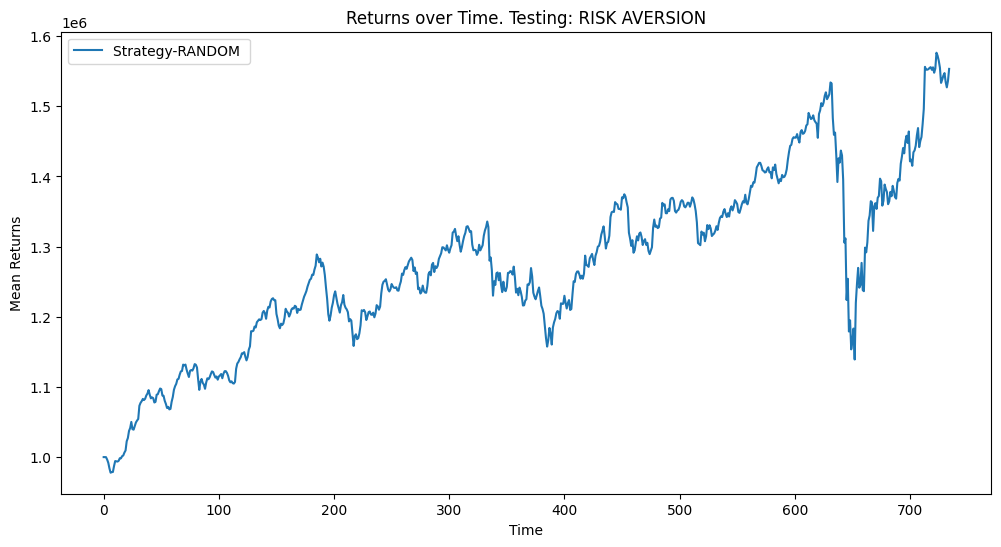

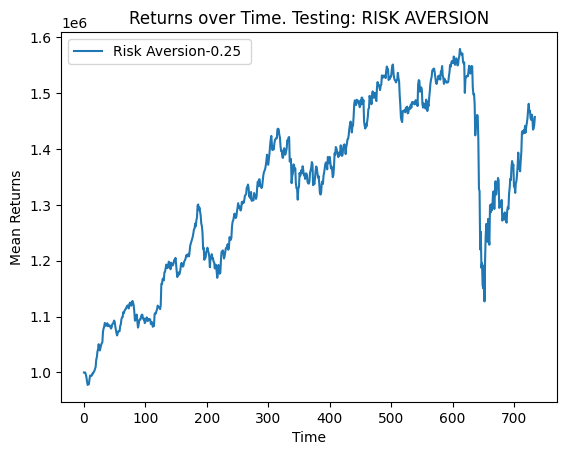

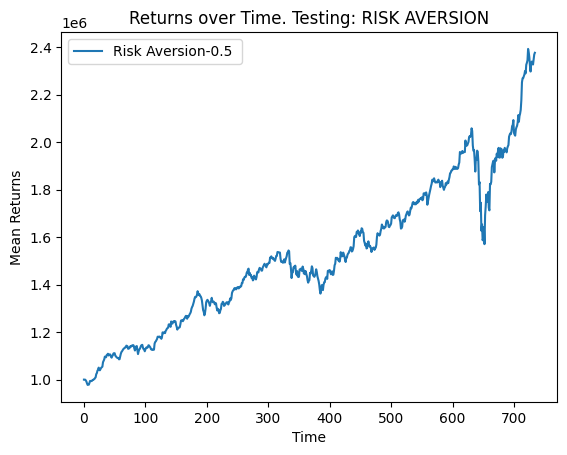

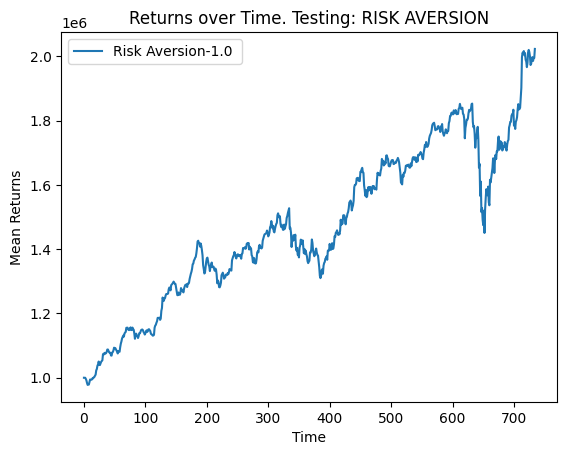

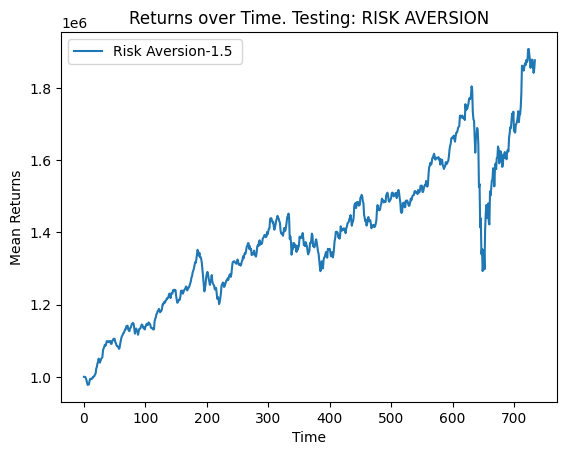

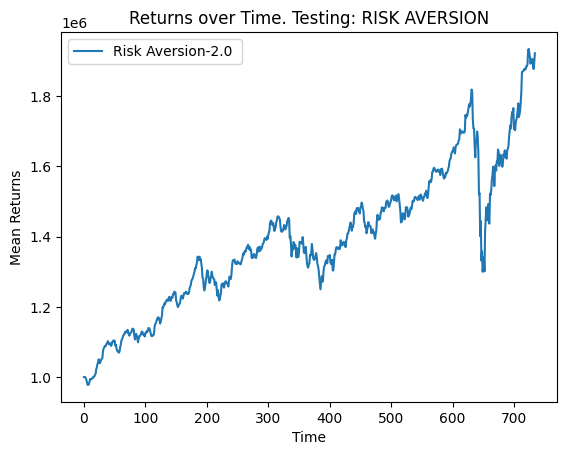

TESTING LSTM OUTPUT SIZE


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | LSTM Output Size-64 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
113.31,27.3283,0.0947,733


1 Epochs takes: 259.97 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | LSTM Output Size-64 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
152.57,27.721,0.1063,733


2 Epochs takes: 514.01 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | LSTM Output Size-64 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
146.42,29.013,0.0998,733


3 Epochs takes: 768.44 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | LSTM Output Size-64 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
159.4,28.6869,0.1069,733


4 Epochs takes: 1021.80 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | LSTM Output Size-64 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
174.27,28.8691,0.1111,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | LSTM Output Size-128 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
43.57,26.2823,0.0418,733


1 Epochs takes: 253.30 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | LSTM Output Size-128 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
36.74,26.4958,0.0374,733


2 Epochs takes: 511.07 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | LSTM Output Size-128 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
56.91,24.6084,0.0546,733


3 Epochs takes: 764.46 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | LSTM Output Size-128 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.35,26.2636,0.0527,733


4 Epochs takes: 1018.25 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | LSTM Output Size-128 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
66.91,26.0566,0.0586,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | LSTM Output Size-256 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
81.23,22.746,0.0814,733


1 Epochs takes: 256.36 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | LSTM Output Size-256 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
74.57,22.916,0.0767,733


2 Epochs takes: 512.60 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | LSTM Output Size-256 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
81.59,23.5958,0.0805,733


3 Epochs takes: 769.43 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | LSTM Output Size-256 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
76.61,24.9764,0.0749,733


4 Epochs takes: 1025.54 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | LSTM Output Size-256 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
76.53,25.8023,0.0713,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | LSTM Output Size-512 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
78.46,29.4613,0.0679,733


1 Epochs takes: 260.28 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | LSTM Output Size-512 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
67.19,26.0168,0.0654,733


2 Epochs takes: 521.47 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | LSTM Output Size-512 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
62.99,25.4236,0.0662,733


3 Epochs takes: 782.29 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | LSTM Output Size-512 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.22,26.1372,0.0694,733


4 Epochs takes: 1063.76 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | LSTM Output Size-512 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.97,26.8969,0.0469,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | LSTM Output Size-1024 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
91,24.4867,0.0852,733


1 Epochs takes: 315.20 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | LSTM Output Size-1024 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
93.93,21.6677,0.0893,733


2 Epochs takes: 591.76 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | LSTM Output Size-1024 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
93.97,20.8653,0.0905,733


3 Epochs takes: 861.40 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | LSTM Output Size-1024 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
104.64,21.8865,0.094,733


4 Epochs takes: 1131.05 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | LSTM Output Size-1024 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
104.24,22.2961,0.0933,733


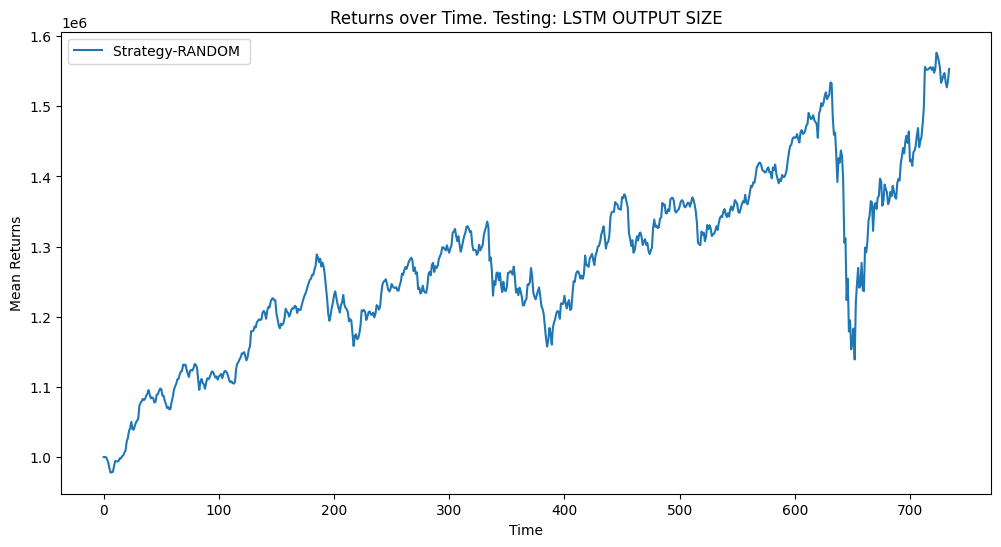

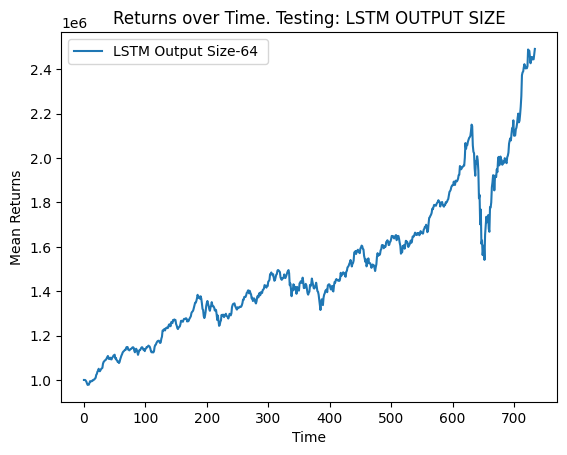

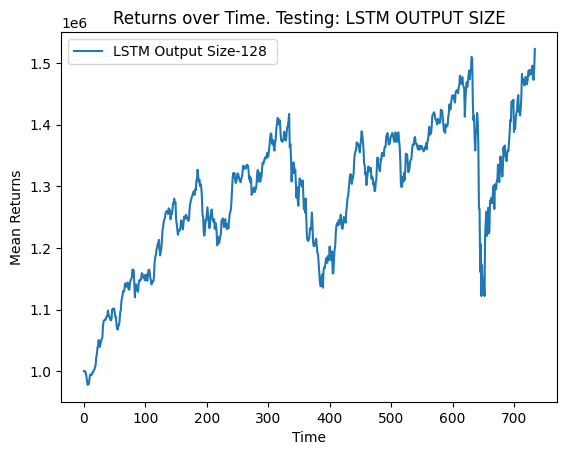

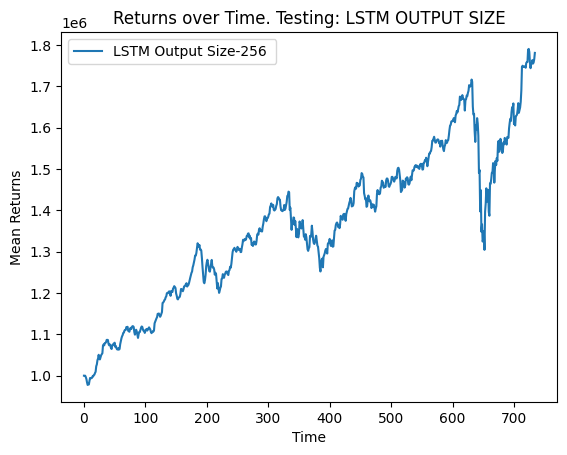

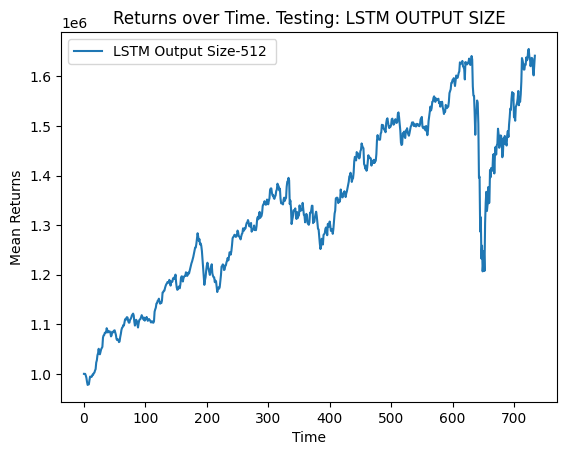

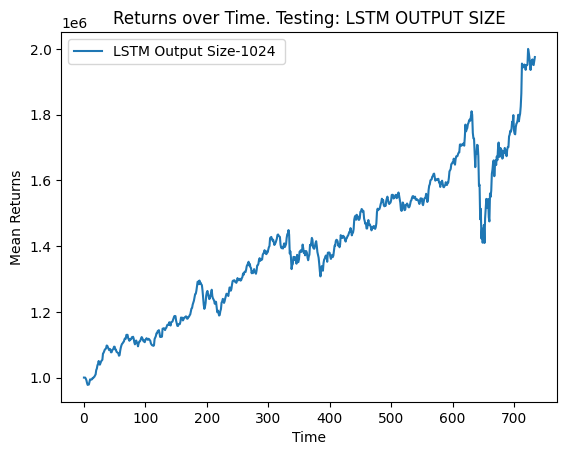

TESTING REWARD FUNCTION


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Reward Function-Differential Sharpe Ratio_0.01 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.91,24.4082,0.069,733


1 Epochs takes: 256.90 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Reward Function-Differential Sharpe Ratio_0.01 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
163.48,26.2548,0.1074,733


2 Epochs takes: 511.53 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Reward Function-Differential Sharpe Ratio_0.01 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
113.49,26.4209,0.0858,733


3 Epochs takes: 765.49 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Reward Function-Differential Sharpe Ratio_0.01 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
142.07,30.2789,0.0917,733


4 Epochs takes: 1020.06 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Reward Function-Differential Sharpe Ratio_0.01 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
142.26,29.616,0.0908,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Reward Function-Differential Sharpe Ratio_0.05 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
105.53,19.0985,0.0937,733


1 Epochs takes: 254.84 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Reward Function-Differential Sharpe Ratio_0.05 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
127.56,22.1295,0.0985,733


2 Epochs takes: 509.35 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Reward Function-Differential Sharpe Ratio_0.05 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
142.36,26.4408,0.0938,733


3 Epochs takes: 763.45 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Reward Function-Differential Sharpe Ratio_0.05 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
124.75,27.2993,0.0842,733


4 Epochs takes: 1017.44 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Reward Function-Differential Sharpe Ratio_0.05 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
118.82,27.8019,0.0815,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
-3.74,28.4721,-0.0055,733


1 Epochs takes: 254.19 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
-1.19,29.3681,-0.0016,733


2 Epochs takes: 508.48 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
-5.34,28.1131,-0.0076,733


3 Epochs takes: 762.99 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
-6.24,29.4672,-0.0091,733


4 Epochs takes: 1016.31 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
-12.14,31.6216,-0.0178,733


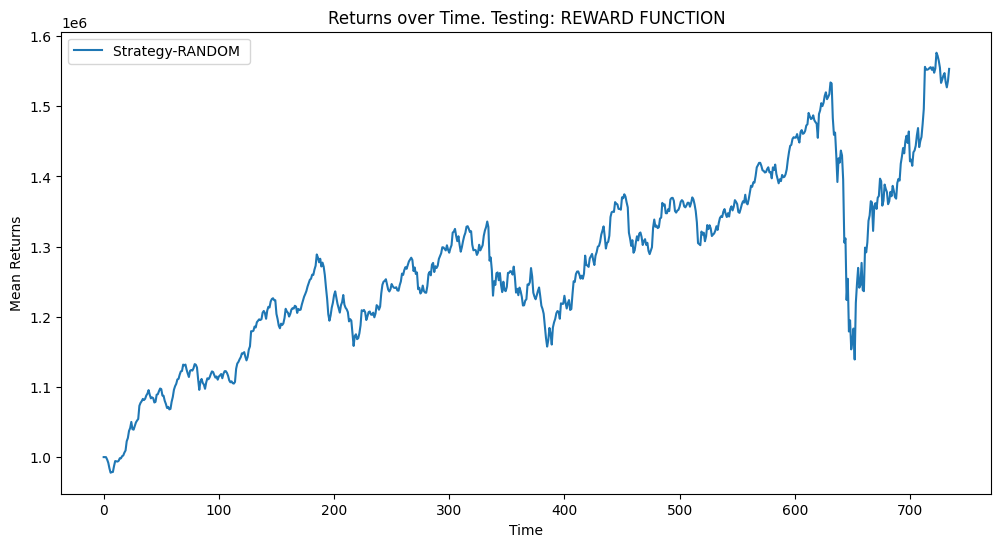

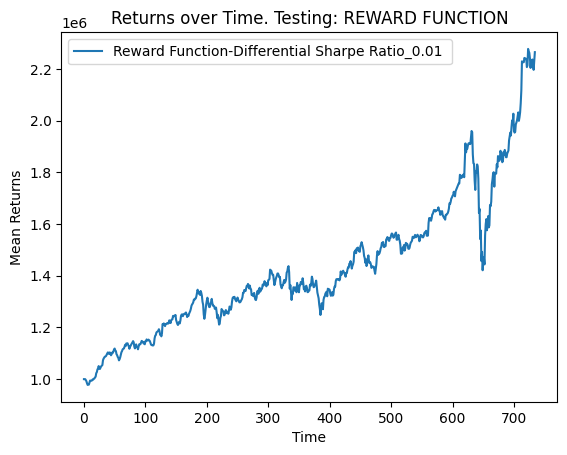

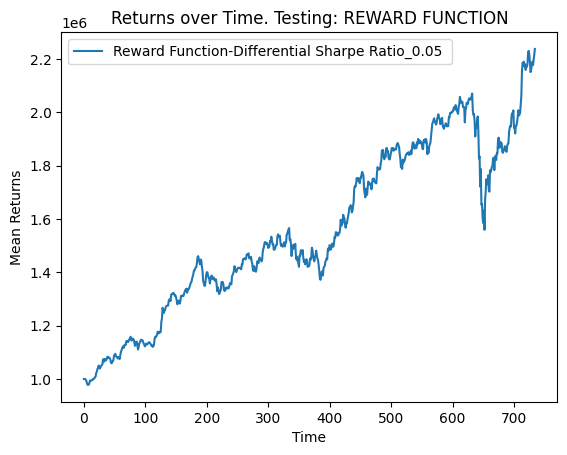

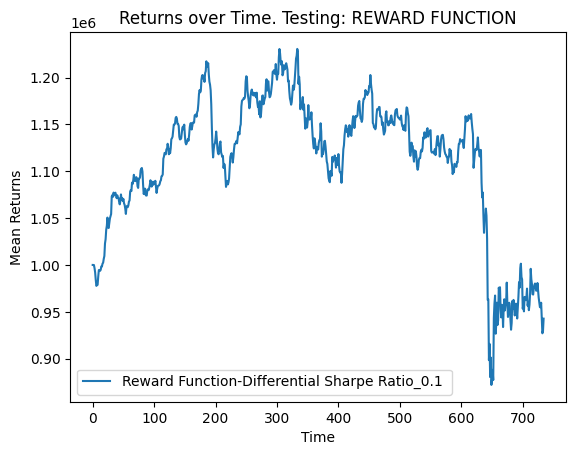

TESTING LEARNING FREQUENCY


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Learning Frequency-146 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
74.73,25.6069,0.0733,733


1 Epochs takes: 236.89 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Learning Frequency-146 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
71.25,24.898,0.0724,733


2 Epochs takes: 472.01 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Learning Frequency-146 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
73.39,24.9687,0.0727,733


3 Epochs takes: 708.46 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Learning Frequency-146 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
63.57,24.8463,0.0656,733


4 Epochs takes: 943.17 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Learning Frequency-146 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
64.13,26.3333,0.0655,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Learning Frequency-73 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
60.21,25.8783,0.0614,733


1 Epochs takes: 239.26 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Learning Frequency-73 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
46.33,26.2005,0.0495,733


2 Epochs takes: 479.24 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Learning Frequency-73 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
45.74,25.1145,0.0508,733


3 Epochs takes: 718.02 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Learning Frequency-73 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
52.93,27.0702,0.0544,733


4 Epochs takes: 956.70 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Learning Frequency-73 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
67.91,27.1316,0.0638,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Learning Frequency-48 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
72.2,25.682,0.07,733


1 Epochs takes: 244.58 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Learning Frequency-48 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
75.34,27.8178,0.0693,733


2 Epochs takes: 488.33 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Learning Frequency-48 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
88.31,26.4048,0.0757,733


3 Epochs takes: 732.85 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Learning Frequency-48 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
104.25,23.5487,0.0863,733


4 Epochs takes: 976.70 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Learning Frequency-48 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
109.32,24.3068,0.0875,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Learning Frequency-36 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
76.95,26.6828,0.0732,733


1 Epochs takes: 250.24 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Learning Frequency-36 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
77.93,27.3988,0.0688,733


2 Epochs takes: 500.69 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Learning Frequency-36 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
101.25,28.1559,0.0781,733


3 Epochs takes: 750.45 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Learning Frequency-36 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
98.9,27.3572,0.081,733


4 Epochs takes: 999.92 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Learning Frequency-36 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
108.46,29.4362,0.0796,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Learning Frequency-29 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
78.46,29.4613,0.0679,733


1 Epochs takes: 259.16 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Learning Frequency-29 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
67.19,26.0168,0.0654,733


2 Epochs takes: 519.26 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Learning Frequency-29 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
62.99,25.4236,0.0662,733


3 Epochs takes: 777.73 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Learning Frequency-29 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.22,26.1372,0.0694,733


4 Epochs takes: 1035.67 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Learning Frequency-29 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.97,26.8969,0.0469,733


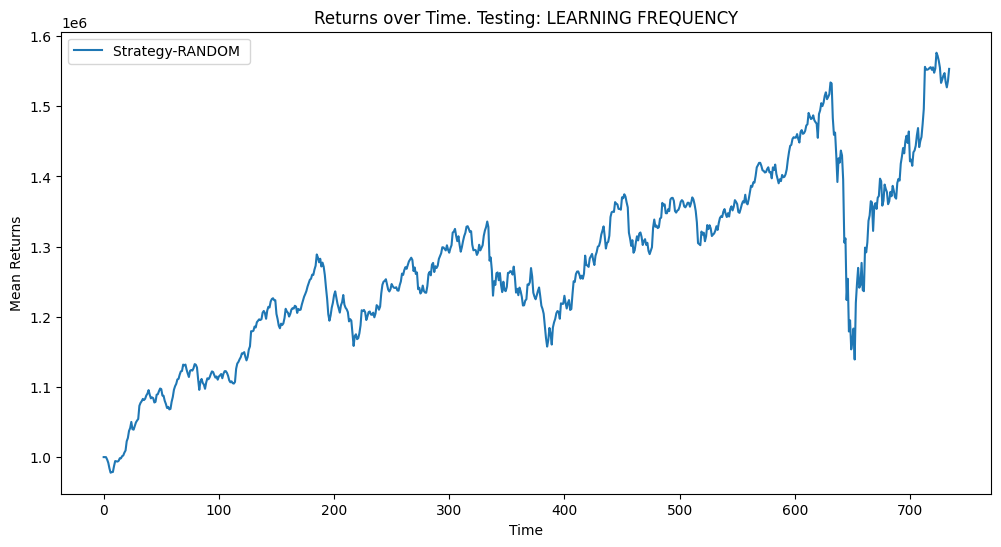

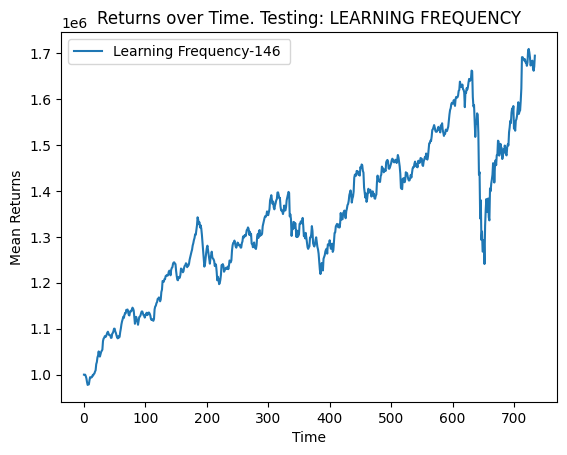

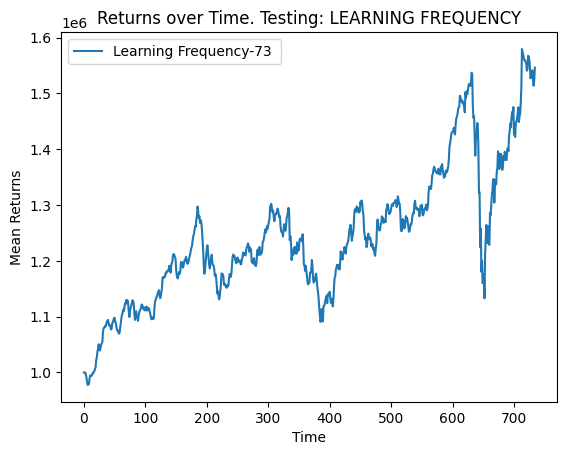

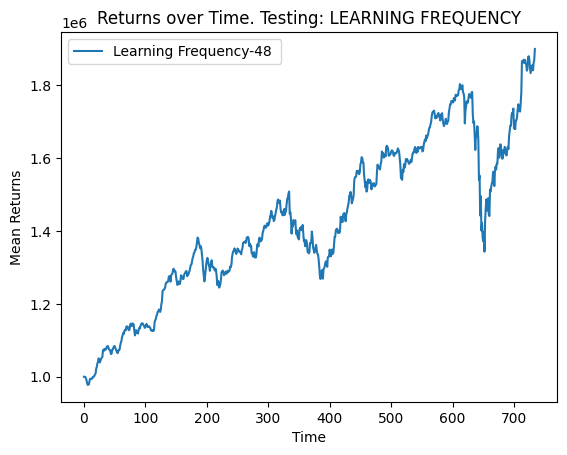

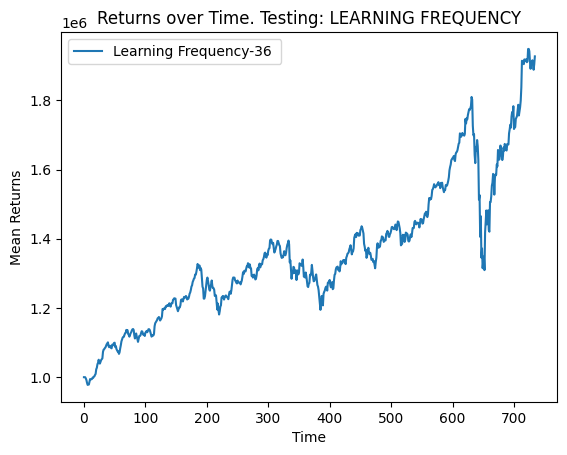

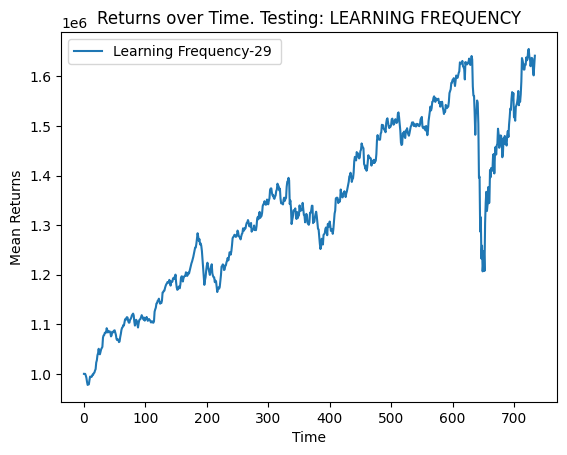

TESTING LEARNING RATE


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Learning Rate-0.0001 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
43.43,28.3844,0.0425,733


1 Epochs takes: 260.84 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Learning Rate-0.0001 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
78.59,27.3638,0.0712,733


2 Epochs takes: 519.44 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Learning Rate-0.0001 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
87.14,23.2064,0.0835,733


3 Epochs takes: 779.35 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Learning Rate-0.0001 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
72.38,25.0778,0.0731,733


4 Epochs takes: 1038.68 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Learning Rate-0.0001 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
61.3,26.0008,0.0637,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Learning Rate-0.0003 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
78.46,29.4613,0.0679,733


1 Epochs takes: 258.63 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Learning Rate-0.0003 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
67.19,26.0168,0.0654,733


2 Epochs takes: 519.64 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Learning Rate-0.0003 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
62.99,25.4236,0.0662,733


3 Epochs takes: 777.90 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Learning Rate-0.0003 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.22,26.1372,0.0694,733


4 Epochs takes: 1037.02 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Learning Rate-0.0003 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.97,26.8969,0.0469,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Learning Rate-0.0005 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
87.72,25.1628,0.0774,733


1 Epochs takes: 259.18 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Learning Rate-0.0005 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
77.59,29.6897,0.0653,733


2 Epochs takes: 517.85 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Learning Rate-0.0005 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
59.73,31.6251,0.0514,733


3 Epochs takes: 776.50 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Learning Rate-0.0005 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
67.74,30.8016,0.0555,733


4 Epochs takes: 1035.46 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Learning Rate-0.0005 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.06,30.064,0.0581,733


Evaluation: 11 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.01,24.0372,0.0586,733


Evaluation: 11 | Learning Rate-0.0007 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
22.33,29.4586,0.0217,733


1 Epochs takes: 259.27 seconds


Evaluation: 22 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
50.64,28.2547,0.0493,733


Evaluation: 22 | Learning Rate-0.0007 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
22.67,29.1226,0.0229,733


2 Epochs takes: 519.55 seconds


Evaluation: 33 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
57.54,25.3665,0.0583,733


Evaluation: 33 | Learning Rate-0.0007 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
28.17,30.8881,0.0273,733


3 Epochs takes: 779.00 seconds


Evaluation: 44 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
70.05,25.3751,0.0741,733


Evaluation: 44 | Learning Rate-0.0007 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
2.21,32.7025,0.0022,733


4 Epochs takes: 1037.23 seconds


Evaluation: 55 | Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
41.44,26.678,0.043,733


Evaluation: 55 | Learning Rate-0.0007 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps
-3.55,32.7916,-0.0037,733


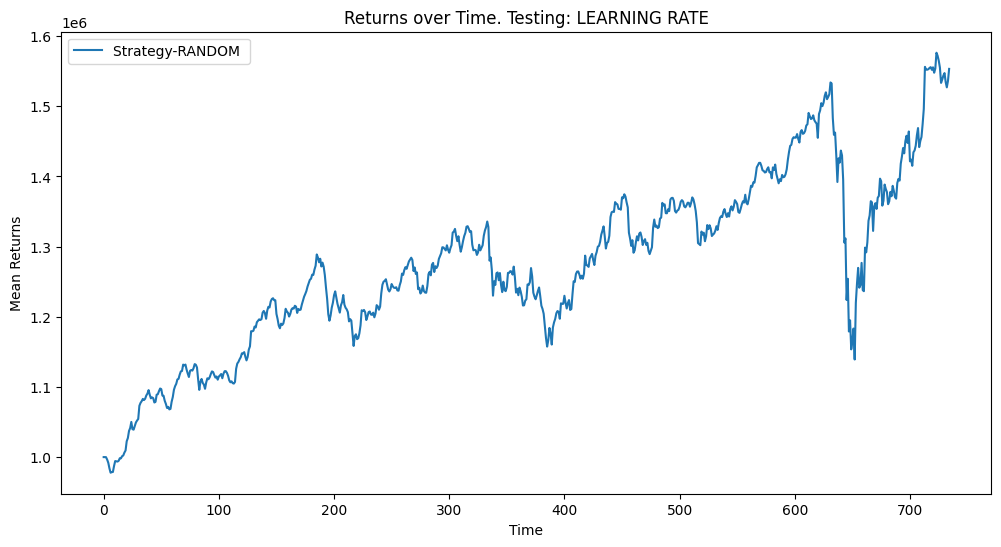

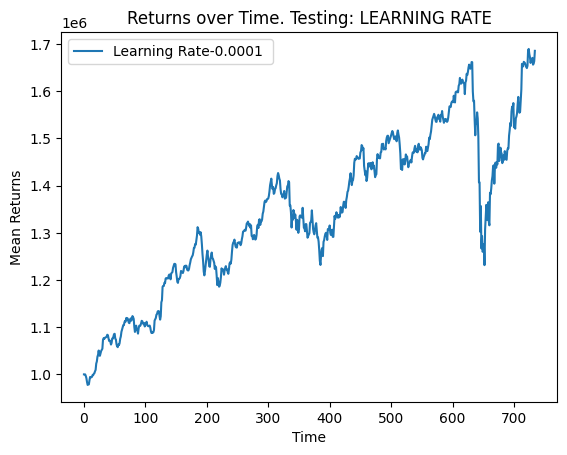

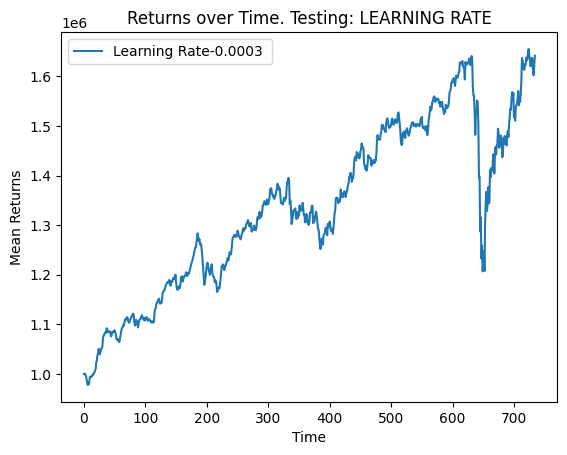

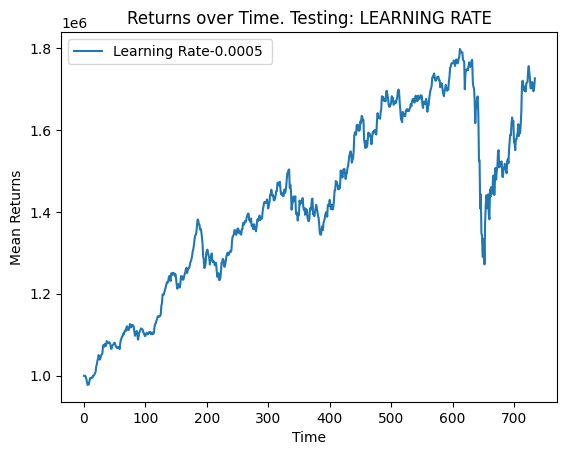

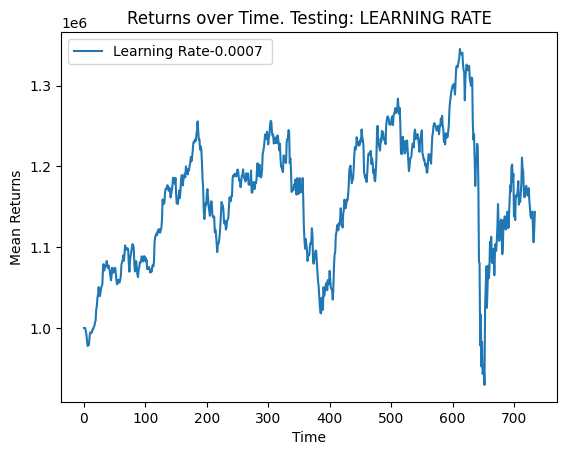

ValueError: too many values to unpack (expected 4)

In [19]:
def sweep():
    for testType, active in TESTING.items():
        if active:
            print(f"TESTING {testType.replace('_', ' ').upper()}")
            testLoops = {
                "RISK AVERSION": lambda: [
                    trainingLoop(riskAversion=risk) for risk in AGENT_RISK_AVERSIONS
                ],
                "LSTM OUTPUT SIZE": lambda: [
                    trainingLoop(lstmOutputSize=size) for size in LSTMOUTPUTSIZES
                ],
                "REWARD FUNCTION": lambda: [
                    trainingLoop(
                        riskAversion=0, rewardFunction=r
                    )
                    for r in REWARD_FUNCTIONS
                ],
                "LEARNING FREQUENCY": lambda: [
                    trainingLoop(freq=fr) for fr in LEARNING_FREQUENCIES
                ],
                "LEARNING RATE": lambda: [
                    trainingLoop(lr=learn) for learn in LEARNING_RATES
                ],
            }
            
            testLoops[testType]()
            break 


def hyperSweep():
    for key in TESTING.keys():
        print("=" * 50)
        TESTING[key] = True
        sweep()
        plotPerformance(key)
        TESTING[key] = False
        print("=" * 50)
    tabulateResults()

TRAIN = True
# Run the sweep
if TRAIN:
    hyperSweep()

In [22]:
tabulateResults()

MEAN RESULTS FOR: Strategy-RANDOM | |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
55.336,25.9423,0.05666,733,0.0852137


MEAN RESULTS FOR: Risk Aversion-0.25 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
45.714,28.6094,0.0464,733,1.01356


MEAN RESULTS FOR: Risk Aversion-0.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
137.6,23.6475,0.10504,733,5.00345


MEAN RESULTS FOR: Risk Aversion-1.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
102.334,22.2093,0.08792,733,3.11867


MEAN RESULTS FOR: Risk Aversion-1.5 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
87.612,28.3158,0.07408,733,4.52964


MEAN RESULTS FOR: Risk Aversion-2.0 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
92.184,28.6272,0.07648,733,1.93035


MEAN RESULTS FOR: LSTM Output Size-64 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
149.194,28.3237,0.10376,733,4.03953


MEAN RESULTS FOR: LSTM Output Size-128 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
52.296,25.9413,0.04902,733,2.15134


MEAN RESULTS FOR: LSTM Output Size-256 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
78.106,24.0073,0.07696,733,0.559448


MEAN RESULTS FOR: LSTM Output Size-512 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
64.166,26.7871,0.06316,733,2.43993


MEAN RESULTS FOR: LSTM Output Size-1024 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
97.556,22.2404,0.09046,733,1.14489


MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio_0.01 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
126.442,27.3958,0.08894,733,6.39863


MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio_0.05 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
123.804,24.554,0.09034,733,2.39684


MEAN RESULTS FOR: Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
-5.73,29.4084,-0.00832,733,0.727032


MEAN RESULTS FOR: Learning Frequency-146 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
69.414,25.3306,0.0699,733,0.936001


MEAN RESULTS FOR: Learning Frequency-73 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
54.624,26.279,0.05598,733,1.69306


MEAN RESULTS FOR: Learning Frequency-48 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
89.884,25.552,0.07776,733,2.9811


MEAN RESULTS FOR: Learning Frequency-36 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
92.698,27.8062,0.07614,733,2.57081


MEAN RESULTS FOR: Learning Frequency-29 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
64.166,26.7871,0.06316,733,2.43993


MEAN RESULTS FOR: Learning Rate-0.0001 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
68.568,26.0067,0.0668,733,3.02607


MEAN RESULTS FOR: Learning Rate-0.0003 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
64.166,26.7871,0.06316,733,2.43993


MEAN RESULTS FOR: Learning Rate-0.0005 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
72.568,29.4686,0.06154,733,1.89572


MEAN RESULTS FOR: Learning Rate-0.0007 | Strategy-PPOLSTM |

Cumulative Return (%),Maximum Pullback (%),Sharpe Ratio,Total Timesteps,Standard Deviation
14.366,30.9927,0.01408,733,2.51664


## 5. Testing Process

### Best Models (if any) Evaluated  - VERY WRONG FOR NOW, IGNORE

In [ ]:
# REPEATS = 50

# # Experiment 1
# EXP_CONFIG = {"Reward" : ["Standard Logarithmic Returns", "Differential Sharpe Ratio_0.01", "CVaR_0.5"],
#                 "LSTM Output Size" : 512, 
#                 "Frequency" : 36,
#                 "Environments" : 0,
#                 "Learning Rate" : 5e-4,
#                 }

# # Very hacky
# # Config 1
# def func():
#     for r in EXP_CONFIG["Reward"]:
#             trainingLoop(
#             riskAversion=(float(r.split("_")[1]) if r.split("_")[0] == "CVaR" else 0),
#             rewardFunction=r.split("_")[0] if "CVaR" in r else r,
#             freq=EXP_CONFIG["Frequency"],
#             parr=EXP_CONFIG["Environments"],
#             lstmOutputSize=EXP_CONFIG["LSTM Output Size"],
#             lr=EXP_CONFIG["Learning Rate"],
#             conf = "Reward Function-" + r + " | " + "Strategy-PPOLSTM" + " | " + "Experiment 1",
#         )

# allResults = defaultdict(list)

# def runFinal(func, folderExtension):
#     #terrible code forgive me
#     global STRATEGIES 
#     STRATEGIES = ["PPOLSTM"]
#     global allResults 
#     global RANDOM_REPEATS
    
#     print("=" * 50)
#     TESTING["REWARD FUNCTION"] = True
#     func()
#     STRATEGIES = ["RANDOM"]
#     while RANDOM_REPEATS > 0:
#         trainingLoop()

#     plotPerformance("REWARD FUNCTION", folderExtension)
#     TESTING["REWARD FUNCTION"] = False
#     print("=" * 50)
#     tabulateResults()
#     allResults = defaultdict(list)
#     RANDOM_REPEATS = 200
    
# RUN_FINAL = False
# if RUN_FINAL:
#     runFinal(func, "Testing")


### Plotting Code